In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19_Radiography_Dataset"
!pip install pip install tensorflow-addons

Mounted at /content/gdrive
 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia'
 Normal			     'Viral Pneumonia.metadata.xlsx'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.5 MB/s eta 0:00:00


In [2]:
import keras 
import pandas as pd
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from glob import glob
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow_addons.layers import InstanceNormalization
from PIL import Image


import gdown
from zipfile import ZipFile
# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

# loading data from gdrive
chest_xray_dataset = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/images")
chest_xray_dataset_annotations = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/metadata.csv")
radiography_dataset = os.path.abspath("/content/gdrive/My Drive/COVID-19_Radiography_Dataset/")
xray_covid19_dataset = os.path.abspath("/content/gdrive/My Drive/xray_dataset_covid19/")



In [3]:
#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---
# taken from https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP_%28z%2Bquantize_method_with_augmentations%2C_user_friendly_interface%29.ipynb#scrollTo=XHyPd4oxVp_l stops colab disconnecting
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
IPython.display.Javascript(js_code)

<IPython.core.display.Javascript object>

Found 7232 files belonging to 1 classes.


<ipython-input-7-aac433845448>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(2, 2, i + 1)


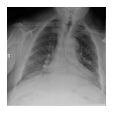

In [ ]:
# load images
image_size = (128, 128)
train_datagen = ImageDataGenerator(rescale=1./255)
dataset = keras.utils.image_dataset_from_directory(
    radiography_dataset + '/COVID', label_mode=None, image_size=image_size, batch_size=32
)
for images in dataset.take(4):
  for i in range(1):
      ax = plt.subplot(2, 2, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.axis("off")


# Code taken from ref https://keras.io/examples/generative/vae/ and refactored

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 3, activation="LeakyReLU", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="LeakyReLU", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="LeakyReLU", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="LeakyReLU", strides=2, padding="same")(x)
x = layers.Conv2D(512, 3, activation="LeakyReLU", strides=2, padding="same")(x)
x = layers.Conv2D(728, 3, activation="LeakyReLU", strides=2, padding="same")(x)
x = layers.Conv2D(1024, 3, activation="LeakyReLU", strides=2, padding="same")(x)
x = layers.Conv2D(2048, 3, activation="LeakyReLU", strides=2, padding="same")(x)
x = layers.Conv2D(4096, 3, activation="LeakyReLU", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="LeakyReLU")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 64))(x)
x = layers.Conv2DTranspose(256, 3, activation="LeakyReLU", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(512, 3, activation="LeakyReLU", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(768, 3, activation="LeakyReLU", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(1024, 3, activation="LeakyReLU", strides=2, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              3072      
                                                                 
 reshape (Reshape)           (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        147712    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 512)      1180160   
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 768)      3539

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mae(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def get_vae():
      return VAE(name='VAERADIOGRAPHYCOVID')

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-3))
vae.fit(dataset, epochs=226 , steps_per_epoch=1)
model = vae.get_vae();
vae.save('/content/gdrive/My Drive/DataAugmentedRadiography_CovidModel/VAE.tf')

Epoch 1/226


ValueError: ignored

In [ ]:
COVID_imgs = vae.inference(1000)

for i in range(COVID_imgs):
  

# Code taken from https://keras.io/examples/generative/dcgan_overriding_train_step/ and refactored  Radiography DCGANs



# DCGAN COVID

In [4]:
# load images
image_size = (128, 128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    radiography_dataset + '/COVID/', label_mode=None, image_size=image_size, batch_size=16,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)

Found 7232 files belonging to 1 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [5]:
num_channels = 3
num_classes = 1
latent_dim = 100

In [6]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

101 4


In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# Create the generator.
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=4, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)           

In [8]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    def get_gan():
      return GAN(name='DC_GAN_RADIOGRAPHY_COVID')


In [9]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVID' + '/' + "generated_img_%03d_%d.png" % (epoch, i))

In [10]:
epochs = 452  # In practice, use ~100 epochs 452


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.001),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs,steps_per_epoch=1, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


model = gan.get_gan
# Save the model
generator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDModel/Generator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDModel/Discriminator',save_format='tf')


Epoch 1/452
1/1 [==============================] - 61s 61s/step - d_loss: 0.7080 - g_loss: 0.6947
Epoch 2/452
1/1 [==============================] - 6s 6s/step - d_loss: 0.5554 - g_loss: 0.6952
Epoch 3/452
1/1 [==============================] - 6s 6s/step - d_loss: 0.4893 - g_loss: 0.6932
Epoch 4/452
1/1 [==============================] - 7s 7s/step - d_loss: 0.4373 - g_loss: 0.6867
Epoch 5/452
1/1 [==============================] - 6s 6s/step - d_loss: 0.4345 - g_loss: 0.6766
Epoch 6/452
1/1 [==============================] - 6s 6s/step - d_loss: 0.4456 - g_loss: 0.6634
Epoch 7/452
1/1 [==============================] - 6s 6s/step - d_loss: 0.4428 - g_loss: 0.6549
Epoch 8/452
1/1 [==============================] - 6s 6s/step - d_loss: 0.4418 - g_loss: 0.6490
Epoch 9/452
1/1 [==============================] - 6s 6s/step - d_loss: 0.4436 - g_loss: 0.6385
Epoch 10/452
1/1 [==============================] - 6s 6s/step - d_loss: 0.4628 - g_loss: 0.6334
Epoch 11/452
1/1 [===================

# Creating DCGAN to only generate masks - test

In [11]:
# load images
image_size = (128, 128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    radiography_dataset + '/COVID/', label_mode=None, image_size=image_size, batch_size=16,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)

Found 7232 files belonging to 1 classes.


In [12]:
num_channels = 3
num_classes = 1
latent_dim = 100

In [13]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# Create the generator.
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(),
        layers.Conv2DTranspose(2048, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)           

In [ ]:
epochs = 226  # In practice, use ~100 epochs 452


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.001),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs,steps_per_epoch=1, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


model = gan.get_gan
# Save the model
generator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDModel/MaskGenerator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_COVIDModel/MaskDiscriminator',save_format='tf')


# Pneumonia DCGAN


In [16]:
# load images
image_size = (128, 128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    radiography_dataset + '/Viral Pneumonia/', label_mode=None, image_size=image_size, batch_size=16,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)

Found 2690 files belonging to 1 classes.


In [17]:
num_channels = 3
num_classes = 1
latent_dim = 128

In [37]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Flatten(),
        layers.Dropout(0),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# Create the generator.
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4 * 4 * 128),
        layers.Reshape((4, 4, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
             layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=3, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 flatten_9 (Flatten)         (None, 32768)           

In [38]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    def get_gan():
      return GAN(name='DC_GAN_RADIOGRAPHY_Pneumonia')


In [39]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PNEUMONIA' + '/' + "generated_img_%03d_%d.png" % (epoch, i))

In [40]:
epochs = 168  # In practice, use ~100 epochs


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs,steps_per_epoch=1, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)
 
# Save the model
generator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PNEUMONIAModel/Generator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/Data_Augmented_Radiography_PNEUMONIAModel/Discriminator',save_format='tf')



Epoch 1/168
1/1 [==============================] - 4s 4s/step - d_loss: 0.7025 - g_loss: 0.6638
Epoch 2/168
1/1 [==============================] - 1s 758ms/step - d_loss: 0.7731 - g_loss: 0.9229
Epoch 3/168
1/1 [==============================] - 1s 764ms/step - d_loss: 4.4265 - g_loss: 0.6864
Epoch 4/168
1/1 [==============================] - 1s 729ms/step - d_loss: 0.5929 - g_loss: 2.3049
Epoch 5/168
1/1 [==============================] - 1s 776ms/step - d_loss: 10.2823 - g_loss: 1.7706
Epoch 6/168
1/1 [==============================] - 1s 737ms/step - d_loss: 0.3491 - g_loss: 2.0849
Epoch 7/168
1/1 [==============================] - 1s 768ms/step - d_loss: 2.5907 - g_loss: 4.9507
Epoch 8/168
1/1 [==============================] - 1s 768ms/step - d_loss: 0.3700 - g_loss: 1.5296
Epoch 9/168
1/1 [==============================] - 1s 750ms/step - d_loss: 9.0148 - g_loss: 4.5993e-06
Epoch 10/168
1/1 [==============================] - 1s 775ms/step - d_loss: 6.9819 - g_loss: 4.2783
Epoch 1